<a href="https://colab.research.google.com/github/kvenkatesh5/AI_monitoring/blob/main/notebooks/OOD_Data_Prepration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Out-of-Distribution (OOD) Data Preparation

The purpose of this notebook is to prepare the data features to be used for statistical process control monitoring in the [CT_SPC_Charts.ipynb](https://github.com/kvenkatesh5/AI_monitoring/blob/main/notebooks/CT_SPC_Charts.ipynb) notebook

## Committing notebook changes to Github

`File` --> `Save a copy in Github`

Then make sure you have the correct repository and leave a commit message like shown below:

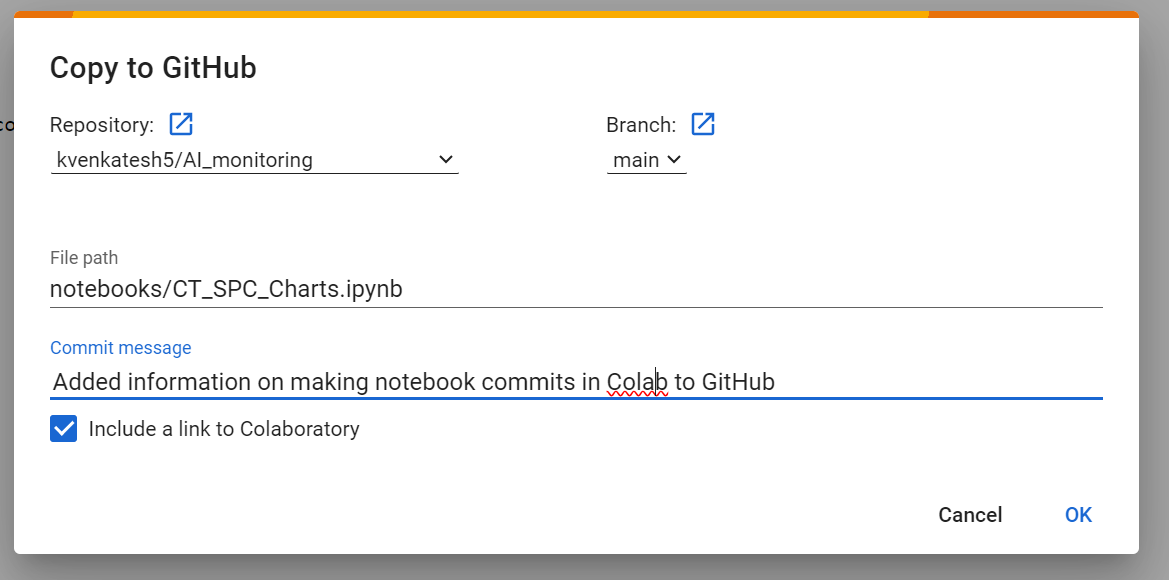

In [1]:
# This code prepares a test set that contains OOD images.
# The OOD images are coming from public datasets such as Medical MNISIT


# Load the required libraries
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
from tensorflow.keras.models import Model
import joblib
import numpy as np
import os
import random
from numpy.linalg import pinv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import numpy as np
from tqdm import tqdm
import numpy as np
import os
from keras.preprocessing import image as keras_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.spatial import distance

# Check if there is a GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [37]:
#install medmnist to include different types of medical images to our dataset
!pip install medmnist -q

In [3]:
from medmnist import OrganAMNIST
from medmnist.info import INFO

# Downloading the validation split of OrganAMNIST
dataset = OrganAMNIST(split="val", download=True)
# Print the label information for OrganAMNIST
organamnist_info = INFO['organamnist']
print("Label Information for OrganAMNIST:", organamnist_info)

100%|██████████| 38247903/38247903 [00:02<00:00, 18504798.21it/s]


Label Information for OrganAMNIST: {'python_class': 'OrganAMNIST', 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/organamnist.npz?download=1', 'MD5': '866b832ed4eeba67bfb9edee1d5544e6', 'task': 'multi-class', 'label': {'0': 'bladder', '1': 'femur-lef

In [45]:
organamnist_dir = 'organamnist_OOD_images'  # or any other path where you want to save the images
os.makedirs(organamnist_dir, exist_ok=True)

# We want to exclude CXR images as the in-distrbution dataset has many CXR images
exclude_labels = {7, 8}  # Labels for 'lung-left' and 'lung-right'

for i, (image, label) in enumerate(dataset):
    if label.item() in exclude_labels:
        continue  # Skip this image

    # Resize and convert to grayscale
    img = image.resize((224, 224)).convert('L')
    img.save(os.path.join(organamnist_dir, f'organamnist_{i:05d}.png'))


In [49]:
from medmnist.dataset import OrganMNISTAxial
OrganMNISTAxial

{'python_class': 'OrganAMNIST',
 'description': 'The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/organamnist.npz?download=1',
 'MD5': '866b832ed4eeba67bfb9edee1d5544e6',
 'task': 'multi-class',
 'label': {'0': 'bladder',
  '1': 'femur-left',
  '2': 'femur-right',
  

In [46]:
# Count the number of images in the organamnist_images directory
image_files = list(Path(organamnist_dir).glob('*.png'))
num_images = len(image_files)
num_images

4449

In [15]:
from collections import Counter

# Count the frequency of each label in the dataset
label_counts = Counter([label.item() for _, label in dataset])
print(label_counts)


Counter({6: 1033, 7: 1033, 8: 1009, 5: 637, 4: 568, 9: 529, 10: 511, 3: 392, 0: 321, 1: 233, 2: 225})


In [30]:
def display_images(images, max_horiz=np.iinfo(int).max):

    images = [Image.open(i) for i in images if (isinstance(i, str) or isinstance(i, Path))]

    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    return im_grid

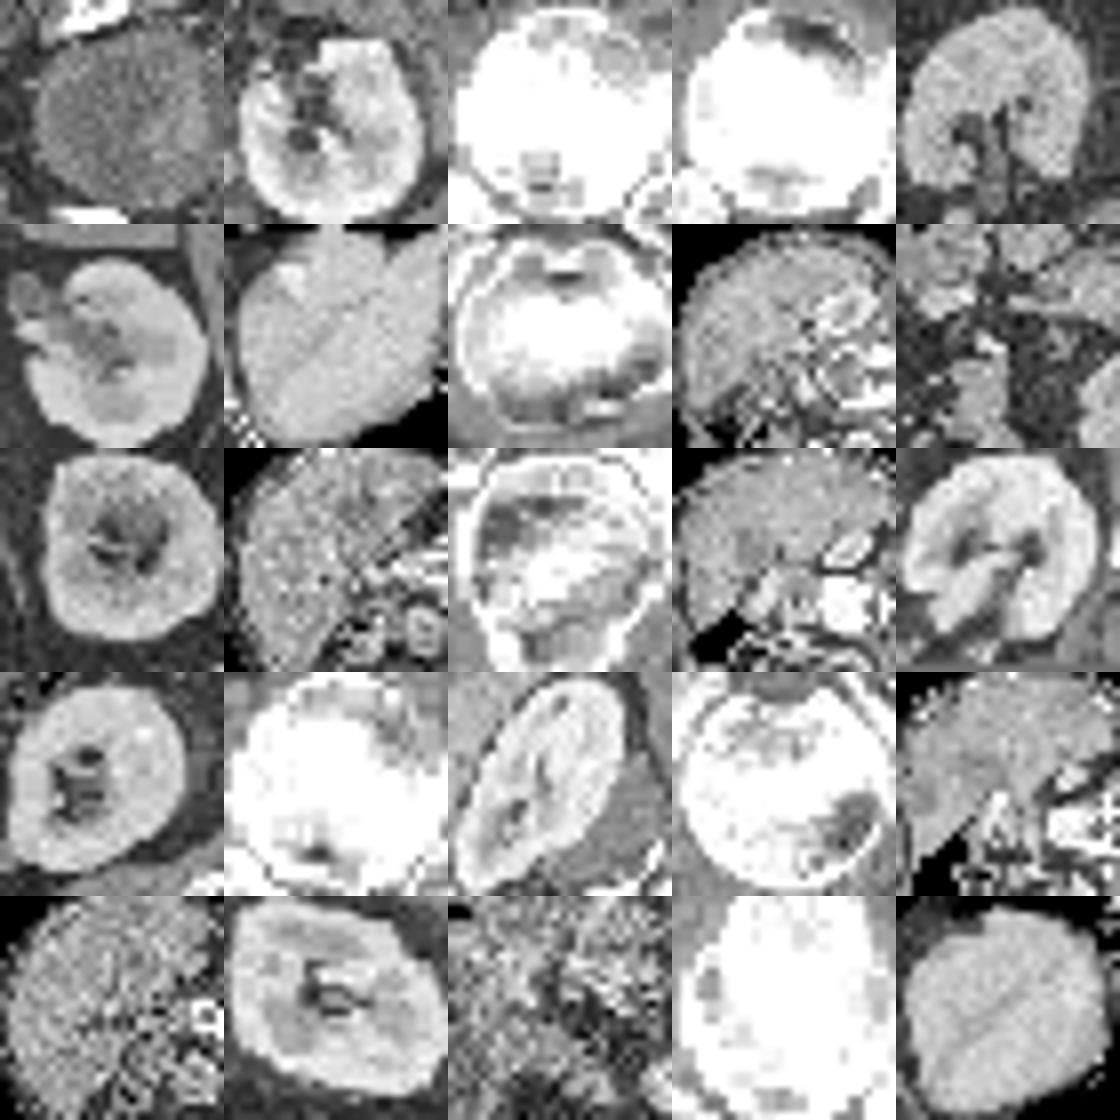

In [34]:
# Randomly select 25 images
random_selected_image_paths = random.sample(image_files, 25)

# Display the randomly selected images
display_images(random_selected_image_paths, max_horiz=5)

In [50]:
from torchvision import transforms
from PIL import Image
import shutil

# Augmentation transformation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224))
])

# Directory paths
ood_test_dir = 'ODD_test'  # Update with the correct path
augmented_dir = 'organamnist_OOD_images'  # or any other path where you want to save the images

os.makedirs(augmented_dir, exist_ok=True)

# Apply augmentation and save images
for img_file in os.listdir(ood_test_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(ood_test_dir, img_file)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img_aug = augmentation(img)
        img_aug.save(os.path.join(augmented_dir, f'aug_{img_file}'))


FileNotFoundError: ignored

In [51]:
augmented_images_count = len(list(Path(augmented_dir).glob('*.png')))
augmented_images_count

for img_file in os.listdir(augmented_dir):
    src_path = os.path.join(augmented_dir, img_file)
    dst_path = os.path.join(organamnist_dir_path, img_file)

    # Check if the destination file already exists to prevent overwriting
    if not os.path.exists(dst_path):
        shutil.move(src_path, dst_path)
    else:
        #print(f"File {img_file} already exists. Not moved.")

# Re-count images in organamnist_images folder
image_paths = list(organamnist_dir_path.glob('*.png'))
total_images_count = len(image_paths)
total_images_count


IndentationError: ignored

In [52]:
# Load a subset of the ImageNet dataset
# (This might download the entire dataset but you can limit the number of examples you use)
imagenet_dataset, ds_info = tfds.load('imagenet_v2', split='test', with_info=True)

# Path for saving ImageNet images
imagenet_dir = '/content/imagenet_images'
os.makedirs(imagenet_dir, exist_ok=True)

# Function to process and save a subset of ImageNet images
def save_imagenet_subset(dataset, target_dir, limit=150, size=(224, 224)):
    for i, example in enumerate(tfds.as_numpy(dataset)):
        if i >= limit:
            break
        # Process and save the image
        image = Image.fromarray(example['image']).resize(size).convert('L')
        image.save(os.path.join(target_dir, f'imagenet_{i}.png'))

# Save a subset of 50 images from ImageNet
save_imagenet_subset(imagenet_dataset, imagenet_dir)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0.incomplete6IRIF5/imagenet_v2-test.tfre…

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


In [ ]:
for img_file in os.listdir(imagenet_dir):
    src_path = os.path.join(imagenet_dir, img_file)
    dst_path = os.path.join(organamnist_dir_path, img_file)
    shutil.move(src_path, dst_path)


In [ ]:
# Refresh the list of image paths in the organamnist_images folder
image_paths = list(organamnist_dir_path.glob('*.png'))
total_images_count = len(image_paths)

# Randomly select images to display
sample_image_paths = random.sample(image_paths, 25)

# Display the selected images and print the total count
display_images(sample_image_paths)
total_images_count


In [ ]:
# Define directories
cxr_source_dir = '/CXR_train_images'  # Update this path to your CXR images directory
in_dist_dir = '/in_dist_pool'
os.makedirs(in_dist_dir, exist_ok=True)

# Count the number of images in the CXR source directory
cxr_image_count = len(cxr_source_dir)
cxr_image_count


In [ ]:
# Define the source directory
cxr_source_dir = '/CXR_train_images'  # Update this path to your CXR images directory

# Identify subfolders (assuming there are only two subfolders for two classes)
class_folders = [f for f in Path(cxr_source_dir).iterdir() if f.is_dir()]
assert len(class_folders) == 2, "There should be exactly two subfolders for classes."

# Sample and copy images from each class
for class_folder in class_folders:
    class_image_paths = list(class_folder.glob('*.png'))  # Update the glob pattern for different image formats
    sampled_images = random.sample(class_image_paths, 500)  # Sample 500 images

    # Copy the selected images
    for img_path in sampled_images:
        shutil.copy(img_path, in_dist_dir)


In [ ]:
# Directory path for in-distribution images
in_dist_dir_path = Path(in_dist_dir)

# Load images from the in-distribution pool directory
in_dist_image_paths = list(in_dist_dir_path.glob('*.png'))

# Select a sample of images to display
sample_in_dist_image_paths = random.sample(in_dist_image_paths, 25)

# Display images
display_images(sample_in_dist_image_paths)


In [ ]:
# Count the images in the in-distribution folder
in_dist_image_count = len(list(in_dist_dir_path.glob('*.png')))

# Count the images in the out-of-distribution folder
out_dist_dir_path = Path(organamnist_dir)
out_dist_image_count = len(list(out_dist_dir_path.glob('*.png')))

in_dist_image_count, out_dist_image_count


In [ ]:
def resize_and_convert_images(image_paths, size=(224, 224)):
    for img_path in image_paths:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(size)
        img.save(img_path)

# Process images in the in-distribution folder
resize_and_convert_images(in_dist_dir_path.glob('*.png'))

# Process images in the out-of-distribution folder
resize_and_convert_images(out_dist_dir_path.glob('*.png'))


In [ ]:
# Load VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

# Function to extract features from a batch of images
def extract_batch_features(batch_images):
    preprocessed_imgs = preprocess_input(batch_images * 255)
    features = model.predict(preprocessed_imgs)
    flattened_features = features.reshape(features.shape[0], -1)
    return flattened_features

In [ ]:
def extract_features_from_images(image_paths):
    all_features = []

    for img_path in tqdm(image_paths):
        # Load and preprocess the image
        img = keras_image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array * 255)

        # Extract features
        features = model.predict(img_array)
        flattened_features = features.reshape(-1)
        all_features.append(flattened_features)

    return np.array(all_features)

# Get a list of image paths
in_dist_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(in_dist_dir) for f in filenames if f.endswith('.png')]
out_dist_image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(organamnist_dir) for f in filenames if f.endswith('.png')]

# Extract features
in_dist_features = extract_features_from_images(in_dist_image_paths)
out_dist_features = extract_features_from_images(out_dist_image_paths)



In [ ]:
# Length and dimensions of the feature vectors
in_dist_feature_length = len(in_dist_features)
in_dist_feature_dimensions = in_dist_features.shape[1]

out_dist_feature_length = len(out_dist_features)
out_dist_feature_dimensions = out_dist_features.shape[1]

(in_dist_feature_length, in_dist_feature_dimensions), (out_dist_feature_length, out_dist_feature_dimensions)


In [ ]:
# Load training features
train_CXR_features = np.load('train_features.npy')

# Load in-distribution test features from CSV
in_dist_data = np.loadtxt('in_distribution_test_features.csv', delimiter=',', dtype=str)
in_dist_filenames = in_dist_data[:, 0]  # Extract filenames
in_dist_features = in_dist_data[:, 1:].astype(float)  # Extract features and convert to float

# Load out-of-distribution test features from CSV
out_dist_data = np.loadtxt('out_distribution_test_features.csv', delimiter=',', dtype=str)
out_dist_filenames = out_dist_data[:, 0]  # Extract filenames
out_dist_features = out_dist_data[:, 1:].astype(float)  # Extract features and convert to float


In [ ]:
print('length of cxt train features', len(train_CXR_features))
print('shape of cxt train features', train_CXR_features.shape)
print('type of cxt train features', type(train_CXR_features))


print('length of in-dist features',len(in_dist_features))
print('shape of in-dist features', in_dist_features.shape)
print('type of in-dist features', type(in_dist_features))


print('length of out-dist features', len(out_dist_data))
print('shape of out-dist features', out_dist_data.shape)
print('type of out-dist features', type(out_dist_data))




In [ ]:
# Function to compute cosine similarity
def compute_cosine_similarity(tr_features_, tt_features_):
    centroid = np.mean(tr_features_, axis=0)
    similarities = [1 - distance.cosine(feature, centroid) for feature in tt_features_]
    return similarities



# Cosine Similarity: Control Limits Calculation
cosine_train_similarities = compute_cosine_similarity(train_CXR_features, train_CXR_features)
cosine_mean_train = np.mean(cosine_train_similarities)
cosine_std_train = np.std(cosine_train_similarities)
cosine_UCL_train = cosine_mean_train + 3 * cosine_std_train
cosine_LCL_train = cosine_mean_train - 3 * cosine_std_train
print("MEAN: {} | STD: {}".format(cosine_mean_train, cosine_std_train))

# Median and Median Absolute Deviation (MAD)
median_train = np.median(cosine_train_similarities)
mad_train = np.median(np.abs(cosine_train_similarities - median_train))

# Percentiles (e.g., 95th and 99th percentiles)
percentile_95_train = np.percentile(cosine_train_similarities, 95)
percentile_99_train = np.percentile(cosine_train_similarities, 99)

# Range (R) and Interquartile Range (IQR)
range_train = np.ptp(cosine_train_similarities)
iqr_train = np.percentile(cosine_train_similarities, 75) - np.percentile(cosine_train_similarities, 25)



# Print or use the statistics as required for setting thresholds
print("Cosine Similarity Mean:", cosine_mean_train)
print("Cosine Similarity Standard Deviation:", cosine_std_train)
print("Cosine Similarity Median:", median_train)
print("Cosine Similarity MAD:", mad_train)
print("Cosine Similarity 95th Percentile:", percentile_95_train)
print("Cosine Similarity 99th Percentile:", percentile_99_train)
print("Cosine Similarity Range (R):", range_train)
print("Cosine Similarity Interquartile Range (IQR):", iqr_train)


# Compute cosine similarity statistics for in-distribution test features
cosine_in_dist_similarities = compute_cosine_similarity(train_CXR_features, in_dist_features)
cosine_mean_in_dist = np.mean(cosine_in_dist_similarities)
cosine_std_in_dist = np.std(cosine_in_dist_similarities)
print("MEAN in_dist_test: {} | STD in_dist_test: {}".format(cosine_mean_in_dist, cosine_std_in_dist))

# Compute cosine similarity statistics for out-of-distribution test features
cosine_out_dist_similarities = compute_cosine_similarity(train_CXR_features, out_dist_features)
cosine_mean_out_dist = np.mean(cosine_out_dist_similarities)
cosine_std_out_dist = np.std(cosine_out_dist_similarities)
print("MEAN out_dist_test: {} | STD out_dist_test: {}".format(cosine_mean_out_dist, cosine_std_out_dist))




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(12, 6))

# Train Features Histogram
plt.subplot(1, 3, 1)
plt.hist(cosine_train_similarities, bins=50, color='blue', alpha=0.7)
plt.title('Train Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# In-Dist Test Features Histogram
plt.subplot(1, 3, 2)
plt.hist(cosine_in_dist_similarities, bins=50, color='green', alpha=0.7)
plt.title('In-Dist Test Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Out-Dist Test Features Histogram
plt.subplot(1, 3, 3)
plt.hist(cosine_out_dist_similarities, bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Test Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
